# Breast Cancer Detection - CRISP-DM Project (Educational Version)

## Objective

This notebook implements and compares 6 machine learning algorithms for breast cancer detection, following CRISP-DM methodology.

## Structure

- CRISP-DM methodology
- 6 different algorithms for comparison
- Detailed explanations of architectural and hyperparameter choices

## 1. Business Understanding

### Goal
Predict whether a breast tumor is malignant or benign using machine learning algorithms.

### Context
- Binary classification problem: 2 classes (Benign/Malignant)
- Medical data: Features measured from tumor cells
- Critical application: Medical diagnosis assistance

## 2. Data Understanding

In [1]:
# ============================================================================
# IMPORTATION DES BIBLIOTHÈQUES
# ============================================================================
# Cette cellule importe toutes les bibliothèques nécessaires au projet

# --- Bibliothèques de base pour la manipulation de données ---
import pandas as pd  # Manipulation de DataFrames (tableaux de données)
import numpy as np   # Calculs numériques et opérations sur tableaux
import matplotlib.pyplot as plt  # Visualisation de graphiques
import seaborn as sns  # Visualisation statistique avancée (basé sur matplotlib)

# --- Scikit-learn : Machine Learning et préprocessing ---
from sklearn.model_selection import train_test_split  # Division train/test
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Standarisation et Normalisation
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression  # Régression linéaire avec SGD et Logistic Regression
from sklearn.svm import SVC  # Support Vector Machine (SVM)
from sklearn.neural_network import MLPClassifier  # Multi-Layer Perceptron (réseau de neurones)
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors (KNN)

# --- Métriques d'évaluation ---
from sklearn.metrics import (
    confusion_matrix,    # Matrice de confusion (TP, TN, FP, FN)
    roc_auc_score,       # Aire sous la courbe ROC (mesure de performance)
    roc_curve,           # Courbe ROC (True Positive Rate vs False Positive Rate)
    accuracy_score,      # Précision (pourcentage de prédictions correctes)
    recall_score,        # Rappel (Sensibilité - capacité à détecter les vrais positifs)
    precision_score,     # Précision (proportion de vrais positifs parmi les prédictions positives)
    f1_score,            # Score F1 (moyenne harmonique de précision et rappel)
    mean_squared_error   # Erreur quadratique moyenne (pour régression)
)

# --- TensorFlow/Keras : Deep Learning (optionnel) ---
# On utilise try/except car TensorFlow n'est pas toujours installé
try:
    from tensorflow.keras.models import Sequential  # Modèle séquentiel (couches empilées)
    from tensorflow.keras.layers import GRU, Dense, Dropout, Input  # Types de couches
    # GRU: Gated Recurrent Unit (réseau récurrent)
    # Dense: Couche fully-connected (tous les neurones connectés)
    # Dropout: Régularisation (désactive aléatoirement des neurones)
    # Input: Couche d'entrée explicite
    from tensorflow.keras.callbacks import EarlyStopping  # Arrêt anticipé pour éviter le surapprentissage
    from tensorflow.keras.optimizers import Adam  # Optimiseur Adam (adaptatif)
    TENSORFLOW_AVAILABLE = True  # Flag indiquant que TensorFlow est disponible
except ImportError:
    # Si TensorFlow n'est pas installé, on continue sans (pour les modèles basiques)
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow non disponible - Le modèle GRU-SVM ne sera pas entraîné")

# Configuration du style des graphiques
sns.set_style("whitegrid")  # Fond blanc avec grille (style propre et lisible)

In [2]:
# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================
# Lecture du fichier CSV contenant les données sur les tumeurs du sein

df = pd.read_csv('data.csv')  # Charge le fichier CSV dans un DataFrame pandas
# Le DataFrame 'df' contient toutes les observations (lignes) et caractéristiques (colonnes)

df.head()  # Affiche les 5 premières lignes pour avoir un aperçu des données
# Utile pour vérifier que les données sont chargées correctement

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# ============================================================================
# EXPLORATION INITIALE DES DONNÉES
# ============================================================================
# Cette cellule donne un aperçu général de la structure du dataset

# df.shape retourne un tuple (nombre_lignes, nombre_colonnes)
print(f"Dataset shape: {df.shape}")  # Exemple: (569, 33) = 569 échantillons, 33 colonnes
print(f"Features: {df.shape[1] - 1}")  # Nombre de features (colonnes - 1 car on exclut la colonne 'diagnosis')
print(f"Samples: {df.shape[0]}")  # Nombre d'échantillons (patients/tumeurs)

# df.info() affiche des informations détaillées sur chaque colonne :
# - Nom de la colonne
# - Nombre de valeurs non-nulles
# - Type de données (int64, float64, object, etc.)
df.info()
# Utile pour détecter les valeurs manquantes et comprendre les types de données

Dataset shape: (569, 33)
Features: 32
Samples: 569
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 

### 📊 Aperçu du Dataset

**Informations clés :**
- 569 samples: Number of tumors analyzed
- 30 features: Measured characteristics (radius, texture, perimeter, etc.)
- 1 target variable: diagnosis (B = Benign, M = Malignant)
- 3 additional columns: id, Unnamed: 32 (empty), diagnosis

Feature structure:
The 30 features are derived from 10 base measurements:
- Mean: features 0-9
- Standard Error: features 10-19
- Worst: features 20-29

In [4]:
# ============================================================================
# VÉRIFICATION DES VALEURS MANQUANTES
# ============================================================================
# Les valeurs manquantes peuvent affecter les performances des modèles
# Il est crucial de les identifier avant le preprocessing

# df.isnull() retourne un DataFrame booléen (True si valeur manquante, False sinon)
# .sum().sum() additionne toutes les valeurs True dans tout le DataFrame
missing_count = df.isnull().sum().sum()  # Nombre total de valeurs manquantes
print(f"Total missing values: {missing_count}")


Total missing values: 569


In [5]:
# ============================================================================
# STATISTIQUES DESCRIPTIVES
# ============================================================================
# .describe() fournit un résumé statistique de toutes les colonnes numériques

df.describe()
# Retourne pour chaque colonne numérique :
# - count : Nombre de valeurs non-nulles
# - mean : Moyenne
# - std : Écart-type (dispersion des données)
# - min : Valeur minimale
# - 25% : Premier quartile (25% des valeurs sont en dessous)
# - 50% : Médiane (50% des valeurs sont en dessous)
# - 75% : Troisième quartile (75% des valeurs sont en dessous)
# - max : Valeur maximale
# Utile pour détecter les valeurs aberrantes et comprendre la distribution des données

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


### 📐 Structure des Features

Le dataset contient **30 features** dérivées de **10 mesures de base** :
- Mean: features 0-9 - Average value of each characteristic
- Standard Error: features 10-19 - Measurement variability
- Worst: features 20-29 - Most problematic observed value

Example: For cell radius:
- radius_mean: Average radius
- radius_se: Radius standard error
- radius_worst: Largest observed radius

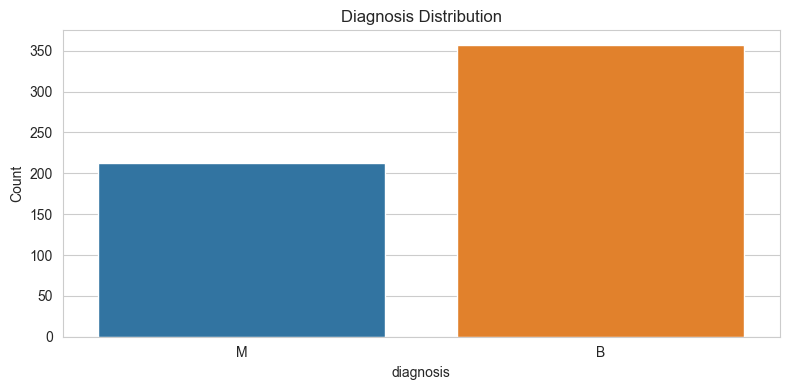

Class distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64
Imbalance ratio: 1.68:1 (Benign:Malignant)


In [6]:
# ============================================================================
# DISTRIBUTION DES CLASSES (BÉNIN vs MALIN)
# ============================================================================
# Il est important de vérifier l'équilibre des classes avant l'entraînement

# Création d'une figure pour la visualisation
plt.figure(figsize=(8, 4))  # Taille : 8 pouces de large, 4 pouces de haut

# Comptage du nombre d'occurrences de chaque classe
diagnosis_counts = df['diagnosis'].value_counts()
# Retourne : B = 357, M = 212 (par exemple)

# Création d'un graphique en barres (countplot)
sns.countplot(
    x='diagnosis',  # Variable sur l'axe X
    data=df,  # DataFrame source
    hue='diagnosis',  # Couleur différente pour chaque classe
    legend=False  # Pas de légende (redondant avec les labels)
)
plt.title('Diagnosis Distribution')  # Titre du graphique
plt.ylabel('Count')  # Label de l'axe Y (nombre d'échantillons)
plt.tight_layout()  # Ajuste l'espacement automatiquement
plt.show()  # Affiche le graphique

# Affichage des statistiques de distribution
print(f"Class distribution:\n{diagnosis_counts}")
# Calcul du ratio d'équilibre : Bénin / Malin
print(f"Imbalance ratio: {diagnosis_counts['B'] / diagnosis_counts['M']:.2f}:1 (Benign:Malignant)")
# Ratio > 1 signifie plus de cas bénins que malins
# Ici ~1.68:1 signifie environ 1.68 fois plus de bénins que de malins
# C'est un déséquilibre modéré (acceptable pour ce dataset)

### 📦 Visualisation des Distributions (Boxplots)

Les boxplots (diagrammes en boîte à moustaches) sont utiles pour :
- Visualize distribution of a numeric variable
- Identify outliers
- Observe median, quartiles (Q1, Q3), and interquartile range (IQR)

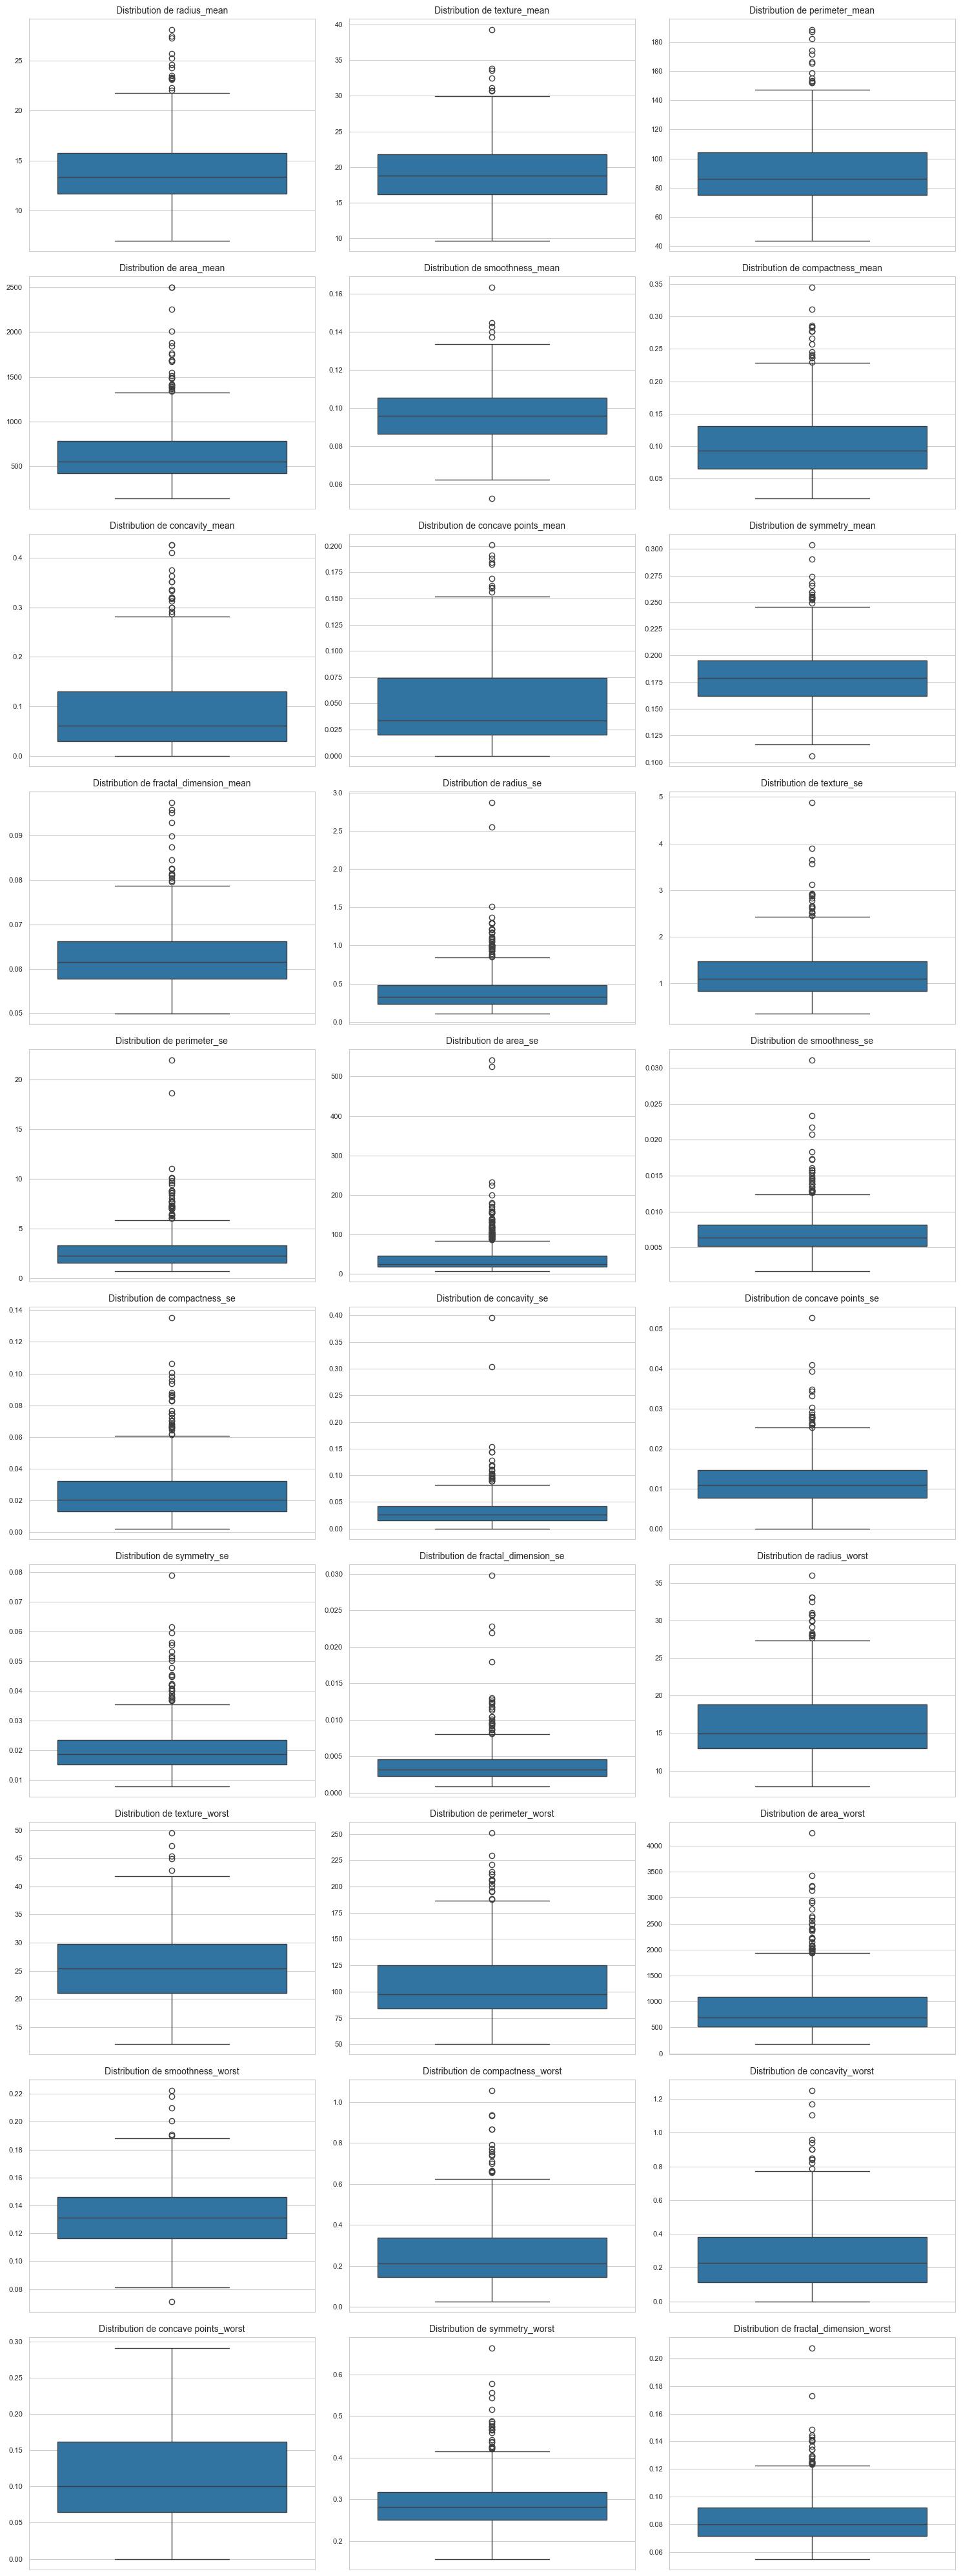

In [7]:
if 'numeric_cols' not in locals():
    numeric_cols = [col for col in df.columns if col not in ['id', 'Unnamed: 32', 'diagnosis']]

n_features = len(numeric_cols)

n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numeric_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f'Distribution de {col}', fontsize=10)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

### 🔗 Analyse de Corrélation

**Pourquoi analyser les corrélations ?**

1. Multicollinearity: Detect highly correlated features (redundant)
   - If two features are highly correlated, remove one
   - Reduces model complexity

2. Understanding relationships: See how features are related
   - Positive correlation: when one feature increases, the other does too
   - Negative correlation: when one increases, the other decreases

3. Feature selection: Identify most important features
   - Features strongly correlated with target = potentially important

Note: High correlations expected since features are derived from same base measurements.


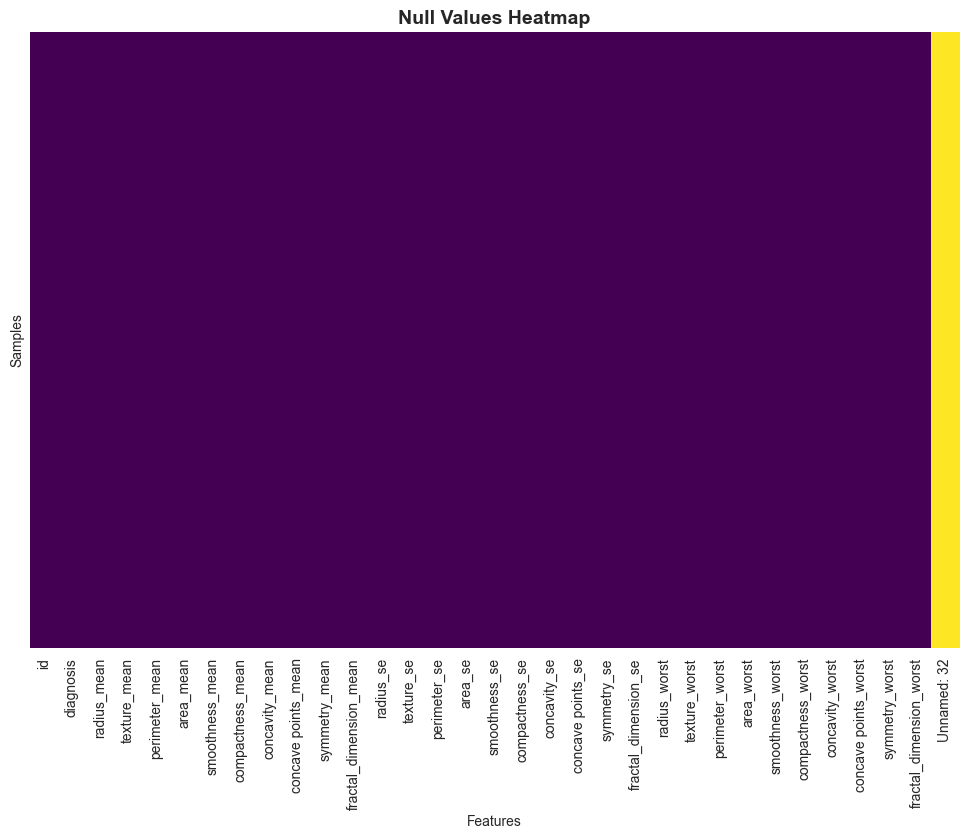

Total missing values: 569
Missing values per column:
Unnamed: 32    569
dtype: int64


In [8]:
# ============================================================================
# NULL VALUES HEATMAP
# ============================================================================
# Visualize missing values in the dataset

plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Null Values Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

print(f"Total missing values: {df.isnull().sum().sum()}")
print("Missing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])


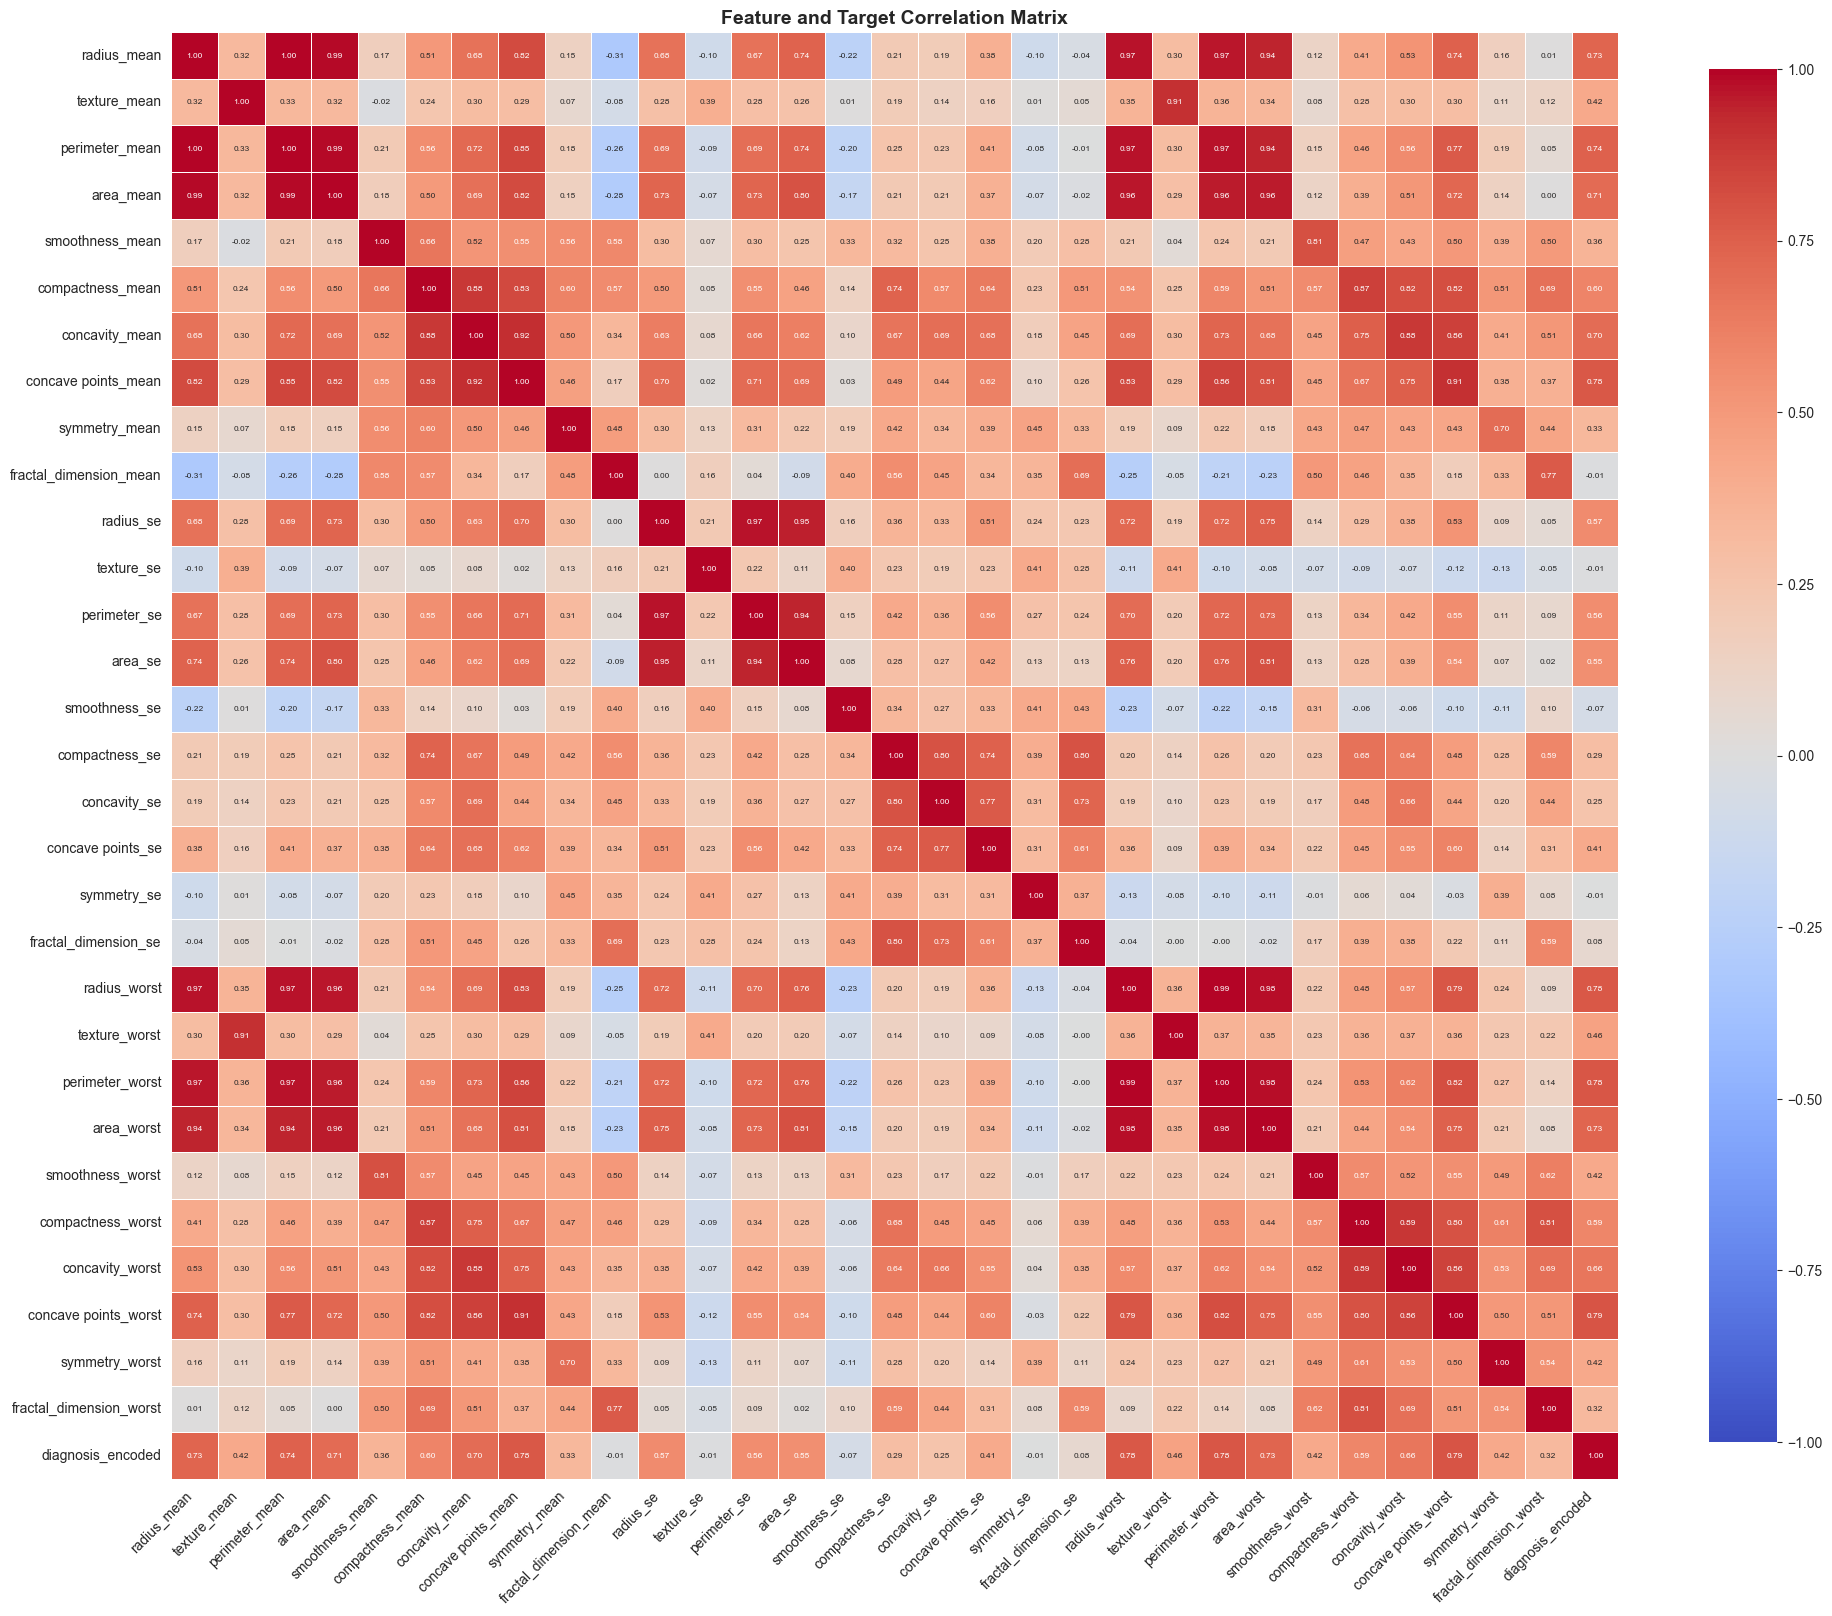

High correlations indicate related features. This is expected as features are derived from the same base measurements.
The last row/column shows correlations between features and the target (diagnosis_encoded).


In [9]:
# ============================================================================
# MATRICE DE CORRÉLATION (INCLUANT LE TARGET)
# ============================================================================
# Visualise les corrélations entre toutes les paires de features ET le target

# Sélection des colonnes numériques (exclut id, Unnamed: 32, et diagnosis)
numeric_cols = [col for col in df.columns if col not in ['id', 'Unnamed: 32', 'diagnosis']]
# Résultat : liste des 30 features numériques

# Encoder le target diagnosis en numérique pour la corrélation
df_encoded = df.copy()
df_encoded['diagnosis_encoded'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Calcul de la matrice de corrélation incluant le target encodé
# .corr() calcule le coefficient de corrélation de Pearson entre toutes les paires
# Valeurs entre -1 (corrélation négative parfaite) et +1 (corrélation positive parfaite)
corr_cols = numeric_cols + ['diagnosis_encoded']
corr_matrix = df_encoded[corr_cols].corr()

# Création d'une grande figure pour visualiser la matrice
plt.figure(figsize=(20, 18))  # Grande taille car 31x31 features + target

# Création de la heatmap (carte de chaleur) - sans masque pour voir toutes les corrélations
sns.heatmap(
    corr_matrix,  # Matrice de corrélation à visualiser
    annot=True,  # Affiche les valeurs numériques dans chaque cellule
    fmt='.2f',  # Format : 2 décimales
    cmap='coolwarm',  # Palette de couleurs : bleu (négatif) → blanc (0) → rouge (positif)
    center=0,  # Centre la palette sur 0
    square=True,  # Cellules carrées (plus lisible)
    cbar_kws={"shrink": 0.8},  # Taille de la barre de couleur (légende)
    vmin=-1, vmax=1,  # Plage de valeurs : -1 à +1
    annot_kws={'size': 6},  # Taille de la police pour les annotations (réduite)
    linewidths=0.5  # Largeur des lignes entre les cellules
)
plt.title('Feature and Target Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("High correlations indicate related features. This is expected as features are derived from the same base measurements.")
print("The last row/column shows correlations between features and the target (diagnosis_encoded).")
# Les corrélations élevées sont normales ici car les features partagent les mêmes mesures de base


In [10]:
# ============================================================================
# NETTOYAGE ET PRÉPARATION DES DONNÉES + SMOTE
# ============================================================================

# --- Imports nécessaires ---
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# --- Étape 1 : Suppression des colonnes non pertinentes ---
df = df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

# --- Étape 2 : Encodage de la variable cible (diagnosis) ---
# 'M' (Malignant) → 1, 'B' (Benign) → 0
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

# --- Étape 3 : Séparation des features (X) et de la cible (y) ---
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# --- Étape 4 : Division Train / Test (stratifiée) ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Affichage des statistiques AVANT SMOTE
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nTrain class distribution (before SMOTE):")
print(f"  Benign (0): {np.bincount(y_train)[0]}")
print(f"  Malignant (1): {np.bincount(y_train)[1]}")

print("\nTest class distribution:")
print(f"  Benign (0): {np.bincount(y_test)[0]}")
print(f"  Malignant (1): {np.bincount(y_test)[1]}")

# --- Étape 5 : Standardisation (Z-score) ---
scaler = StandardScaler()

# Fit sur TRAIN uniquement (évite le data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nStandardization applied: mean = 0, std = 1")

# --- Étape 6 : Rééquilibrage des classes avec SMOTE (TRAIN seulement) ---
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Affichage des statistiques APRÈS SMOTE
print("\nTrain class distribution (after SMOTE):")
print(f"  Benign (0): {np.bincount(y_train_smote)[0]}")
print(f"  Malignant (1): {np.bincount(y_train_smote)[1]}")

Train set: 398 samples (69.9%)
Test set: 171 samples (30.1%)

Train class distribution (before SMOTE):
  Benign (0): 250
  Malignant (1): 148

Test class distribution:
  Benign (0): 107
  Malignant (1): 64

Standardization applied: mean = 0, std = 1

Train class distribution (after SMOTE):
  Benign (0): 250
  Malignant (1): 250


### 4.1 Régression Linéaire (utilisée comme Classifieur)

#### 🎯 Concept
Linear regression is normally used for regression (predicting continuous values), but can be used for binary classification by:
1. Predicting a continuous value (probability)
2. Applying a threshold (0.5) to classify as 0 or 1

Mathematical Formula:
y = w₁x₁ + w₂x₂ + ... + wₙxₙ + b
- w: weights (coefficients) to learn
- x: features
- b: bias (intercept)

Algorithm: SGD (Stochastic Gradient Descent)
- Gradient Descent: Optimizes weights by minimizing error
- Stochastic: Uses random subsample each iteration (faster)
- Advantage: Efficient on large datasets

Chosen Hyperparameters:
- loss='squared_error': Loss function
- learning_rate='constant': Constant learning rate
- eta0=1e-3: Learning rate value (0.001)
- max_iter=3000: Maximum iterations
- random_state=42: For reproducibility


In [11]:
# ============================================================================
# MODÈLE 1 : RÉGRESSION LINÉAIRE (comme classifieur)
# ============================================================================

# Valeurs à tester
learning_rates = [1e-4, 1e-3, 1e-2]
iterations = [1000, 3000, 5000]
best_auc_lr = -np.inf
best_eta = None
best_iter = None


for eta in learning_rates:
    for it in iterations:

        # Création du modèle de régression linéaire avec SGD
        linear_model = SGDRegressor(
            loss='squared_error',        # Fonction de perte : erreur quadratique (L2)
            # Formule MSE : (y_pred - y_true)²
            learning_rate='constant',    # Taux d'apprentissage constant (ne change pas)
            eta0=eta,                    # Valeur initiale du taux d'apprentissage
            # Plus petit = apprentissage plus lent mais plus stable
            max_iter=it,                 # Nombre maximum d'itérations (époques)
            random_state=42              # Graine aléatoire pour reproductibilité
        )

        # Entraînement du modèle sur les données d'entraînement
        linear_model.fit(X_train_smote, y_train_smote)
        # Le modèle apprend les poids (w) et le biais (b) qui minimisent l'erreur

        # --- Prédictions sur le test set ---
        # Prédiction de valeurs continues (probabilités brutes)
        linear_y_test_continuous = linear_model.predict(X_test_scaled)
        # Ces valeurs peuvent être < 0 ou > 1, donc on applique un seuil

        # Conversion en classes binaires : si >= 0.5 → classe 1 (malin), sinon → classe 0 (bénin)
        lr_y_test_pred = (linear_y_test_continuous >= 0.5).astype(int)
        # .astype(int) convertit True/False en 1/0

        # --- Conversion des prédictions en probabilités [0, 1] ---
        # Les valeurs prédites ne sont pas dans [0, 1], donc on les normalise
        from sklearn.preprocessing import MinMaxScaler  # Normalise entre min et max

        prob_scaler = MinMaxScaler()  # Création du scaler pour normaliser entre 0 et 1

        # On calcule les prédictions sur le train pour apprendre min/max
        linear_y_train_continuous = linear_model.predict(X_train_scaled)
        # .reshape(-1, 1) : transforme en colonne (nécessaire pour MinMaxScaler)
        prob_scaler.fit(linear_y_train_continuous.reshape(-1, 1))
        # fit() apprend le min et max des valeurs d'entraînement

        # Application de la normalisation sur les prédictions de test
        lr_y_test_proba = prob_scaler.transform(
            linear_y_test_continuous.reshape(-1, 1)
        ).flatten()
        # transform() : applique la normalisation (valeur - min) / (max - min)
        # .flatten() : transforme la colonne en tableau 1D
        # Résultat : probabilités entre 0 et 1
        auc = roc_auc_score(y_test, lr_y_test_proba)

        if auc > best_auc_lr:
            best_auc_lr = auc
            best_eta = eta
            best_iter = it




### 4.2 Régression Softmax (Logistic Regression)

#### 🎯 Concept
La régression softmax (ou régression logistique) est **spécialement conçue pour la classification**.

Mathematical Formula:
P(y=1|x) = 1 / (1 + e^(-z))
where z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b
- Output: Probability directly between 0 and 1 (no normalization needed)
- Sigmoid function: Transforms linear output to probability

Algorithm: Logistic Regression
- Log Loss: Optimal loss function for binary classification
- Formula: -[y*log(ŷ) + (1-y)*log(1-ŷ)]
- Advantage: Strongly penalizes confident errors (predicting 0.9 for class 0)

Hyperparameters:
- C: Inverse regularization strength (0.01 to 100)
- solver: Optimization algorithm ('lbfgs', 'liblinear', 'newton-cg')
- max_iter: Maximum iterations (1000, 3000, 5000)


In [12]:
# ============================================================================
# MODÈLE 2 : RÉGRESSION SOFTMAX (Logistic Regression)
# ============================================================================

# Valeurs à tester
C_values = [0.01, 0.1, 1, 10, 100]
solvers = ['lbfgs', 'liblinear', 'newton-cg']
iterations = [1000, 3000, 5000]
best_auc_softmax = -np.inf
best_softmax_C = None
best_softmax_solver = None
best_softmax_max_iter = None


for C_val in C_values:
    for solver in solvers:
        for it in iterations:

            # Création du modèle de régression logistique
            softmax_model = LogisticRegression(
                C=C_val,                    # Inverse de la force de régularisation
                # Plus C est grand, moins de régularisation (risque d'overfitting)
                solver=solver,              # Algorithme d'optimisation
                # 'lbfgs' : bon pour petits datasets, 'liblinear' : bon pour binaire
                max_iter=it,               # Nombre maximum d'itérations
                random_state=42            # Reproductibilité
            )

            # Entraînement du modèle
            softmax_model.fit(X_train_smote, y_train_smote)
            # Le modèle apprend les poids qui maximisent la probabilité des classes correctes

            # --- Prédictions sur le test set ---
            # Probabilités : probabilité que chaque échantillon soit de la classe 1 (malin)
            softmax_y_test_proba = softmax_model.predict_proba(X_test_scaled)[:, 1]
            # predict_proba() retourne un array 2D : [[P(classe0), P(classe1)], ...]
            # [:, 1] : prend seulement la probabilité de la classe 1 (malin)

            # Classes prédites : 0 (bénin) ou 1 (malin)
            softmax_y_test_pred = softmax_model.predict(X_test_scaled)
            # predict() retourne directement la classe avec la plus haute probabilité
            auc = roc_auc_score(y_test, softmax_y_test_proba)

            if auc > best_auc_softmax:
                best_auc_softmax = auc
                best_softmax_C = C_val
                best_softmax_solver = solver
                best_softmax_max_iter = it





### 4.3 Multi-Layer Perceptron (MLP) - Réseau de Neurones Profond

#### 🎯 Concept
Réseau de neurones artificiels avec **plusieurs couches cachées** pour capturer des patterns non-linéaires complexes.

#### 🏗️ Architecture
Architecture:
Input (30 features)
    ↓
Hidden Layer 1 (50 neurons)
    ↓
Hidden Layer 2 (50 neurons)
    ↓
Hidden Layer 3 (50 neurons)
    ↓
Output (1 neuron, sigmoid)

Functioning:
- Forward propagation: Data flows from input to output
- Backpropagation: Errors propagate back to adjust weights
- ReLU activation: Introduces non-linearity
- Early stopping: Stops if no improvement (prevents overfitting)

Hyperparameters:
- hidden_layer_sizes=(50, 50, 50): 3 layers of 50 neurons each (experimental reduction)
- learning_rate_init=0.005: Initial learning rate = 0.005 (experimental)
- alpha=0.05: L2 regularization (experimental increase)
- early_stopping=True: Early stopping if validation doesn't improve
- validation_fraction=0.1: 10% of training used for validation


In [13]:
# ============================================================================
# MODÈLE 3 : MULTI-LAYER PERCEPTRON (MLP)
# ============================================================================

# Valeurs à tester
learning_rates = [1e-3, 1e-2]
iterations = [1000, 3000, 5000]
hidden_layers = [(200, 200), (500, 500, 500), (300, 300, 300)]
alphas = [1e-4, 1e-2, 1e-1]
best_auc_mlp = -np.inf
best_mlp_hidden = None
best_mlp_alpha = None


for hls in hidden_layers:
    for alpha in alphas:
        for lr in learning_rates:
            for it in iterations:

                # Création du réseau de neurones avec 3 couches cachées
                mlp_model = MLPClassifier(
                    hidden_layer_sizes=hls,  # Architecture : couches cachées
                    # Plus de neurones = capacité à apprendre des patterns plus complexes
                    # Mais aussi risque de surapprentissage

                    learning_rate_init=lr,  # Taux d'apprentissage initial
                    # Plus élevé que SGD (0.001) car le MLP utilise un scheduler adaptatif

                    alpha=alpha,  # Régularisation L2 (weight decay)
                    # Pénalise les grands poids : α * Σ(w²)
                    # Réduit le surapprentissage en gardant les poids petits

                    max_iter=it,  # Nombre maximum d'itérations

                    early_stopping=True,  # Arrêt anticipé si validation ne s'améliore plus
                    # Évite le surapprentissage en arrêtant avant que le modèle mémorise

                    random_state=42,  # Reproductibilité

                    verbose=0,  # Pas d'affichage pendant l'entraînement (0 = silencieux)

                    validation_fraction=0.1  # 10% des données d'entraînement pour validation
                    # Utilisé pour l'early stopping
                )

                # Entraînement du modèle
                mlp_model.fit(X_train_smote, y_train_smote)
                # Le modèle apprend les poids de toutes les couches via backpropagation

                # --- Prédictions sur le test set ---
                mlp_y_test_proba = mlp_model.predict_proba(X_test_scaled)[:, 1]  # Probabilités
                mlp_y_test_pred = mlp_model.predict(X_test_scaled)  # Classes prédites
                auc = roc_auc_score(y_test, mlp_y_test_proba)

                if auc > best_auc_mlp:
                    best_auc_mlp = auc
                    best_mlp_hidden = hls
                    best_mlp_alpha = alpha

### 4.4 Support Vector Machine (L2-SVM)

#### 🎯 Concept
Trouve la **meilleure frontière de séparation** (hyperplan) entre les classes en maximisant la marge.

#### 📐 Principe
- **Support Vectors** : Points les plus proches de la frontière
- **Marge** : Distance entre la frontière et les points les plus proches
- RBF Kernel: Transforms data to higher dimension for non-linear separation

Hyperparameters:
- C=5: Regularization parameter
  - Small C: More regularization, simpler boundary
  - Large C: Less regularization, complex boundary (overfitting risk)
- kernel='rbf': Radial Basis Function (Gaussian)
  - Allows non-linear boundaries
  - Formula: K(x,y) = exp(-γ||x-y||²)
- gamma='scale': Auto-calculates γ = 1/(n_features * variance)
- probability=True: Enables probability outputs (uses Platt scaling)


In [21]:
# ============================================================================
# MODÈLE 4 : SUPPORT VECTOR MACHINE (L2-SVM)
# ============================================================================

# Valeurs à tester
C_values = [0.1, 1, 5, 10]
iterations = [1000, 3000, 5000]
best_auc_svm = -np.inf
best_svm_C = None


for C_val in C_values:
    for it in iterations:

        # Création du modèle SVM
        svm_model = SVC(
            C=C_val,  # Paramètre de régularisation (selon Table 1 du papier)
            # C contrôle le compromis entre marge large et erreurs de classification
            # C=5 : tolère quelques erreurs pour avoir une marge plus large

            kernel='rbf',  # Radial Basis Function (kernel gaussien)
            # Transforme les données dans un espace de dimension infinie
            # Permet de séparer des données non-linéairement séparables

            gamma='scale',  # Paramètre du kernel RBF
            # 'scale' : calcule automatiquement γ = 1/(n_features * variance(X))
            # Contrôle l'influence de chaque point d'entraînement

            probability=True,  # Active l'estimation de probabilités
            # Utilise Platt scaling (régression logistique sur les scores du SVM)
            # Nécessaire pour obtenir predict_proba()

            random_state=42,  # Reproductibilité

            max_iter=it  # Nombre maximum d'itérations pour la convergence
        )

        # Entraînement du modèle
        svm_model.fit(X_train_smote, y_train_smote)
        # Le SVM trouve les support vectors et construit l'hyperplan optimal

        # --- Prédictions sur le test set ---
        svm_y_test_proba = svm_model.predict_proba(X_test_smote)[:, 1]  # Probabilités
        svm_y_test_pred = svm_model.predict(X_test_scaled)  # Classes prédites
        auc = roc_auc_score(y_test, svm_y_test_proba)
        if auc > best_auc_svm:
          best_auc_svm = auc
          best_svm_C = C_val



NameError: name 'X_test_smote' is not defined

### 4.5 K-Nearest Neighbors (KNN) - Plus Proches Voisins

#### 🎯 Concept
Classifie un point selon la **majorité des classes** de ses **k plus proches voisins** dans l'espace des features.

#### 📐 Principe
1. Pour un nouvel échantillon, trouve les k échantillons les plus proches
2. Regarde les classes de ces k voisins
3. Assigns the majority class

Distances:
- L1 (Manhattan): d = |x₁-y₁| + |x₂-y₂| + ...
  - "City block" distance
  - More robust to outliers
  
- L2 (Euclidean): d = √[(x₁-y₁)² + (x₂-y₂)² + ...]
  - "As the crow flies" distance
  - More sensitive to large differences

Hyperparameters:
- n_neighbors=1: Uses only the nearest neighbor (1-NN)
  - Advantage: Simple and often effective
  - Disadvantage: Sensitive to noise
- metric='minkowski': Generalized metric
- p=1: L1 distance (Manhattan)
- p=2: L2 distance (Euclidean)


In [22]:
# ============================================================================
# MODÈLE 5 : K-NEAREST NEIGHBORS (KNN)
# ============================================================================
# On teste deux distances différentes : L1 (Manhattan) et L2 (Euclidienne)

# Valeurs à tester
k_values = [1, 3, 5, 7, 9]
best_auc_knn_l1 = -np.inf
best_knn_l1_k = None
best_auc_knn_l2 = -np.inf
best_knn_l2_k = None



for k in k_values:

    # --- KNN avec distance L1 (Manhattan) ---
    knn_l1 = KNeighborsClassifier(
        n_neighbors=k,  # Utilise k plus proches voisins
        # Plus simple et souvent performant, mais sensible au bruit

        metric='minkowski',  # Métrique généralisée (L1 et L2 sont des cas particuliers)
        p=1  # p=1 → Distance L1 (Manhattan)
        # Formule : d = |x₁-y₁| + |x₂-y₂| + ... + |xₙ-yₙ|
        # Plus robuste aux valeurs aberrantes
    )
    knn_l1.fit(X_train_smote, y_train_smote)  # "Entraînement" : stocke les données d'entraînement
    # Note : KNN est un "lazy learner" - il ne fait pas vraiment d'entraînement,
    # il stocke juste les données pour les comparer plus tard

    knn_l1_y_test_pred = knn_l1.predict(X_test_scaled)  # Classes prédites
    knn_l1_y_test_proba = knn_l1.predict_proba(X_test_scaled)[:, 1]  # Probabilités
    # Probabilité = proportion de voisins de chaque classe

    # --- KNN avec distance L2 (Euclidienne) ---
    knn_l2 = KNeighborsClassifier(
        n_neighbors=k,  # Même nombre de voisins
        metric='minkowski',  # Même métrique généralisée
        p=2  # p=2 → Distance L2 (Euclidienne)
        # Formule : d = √[(x₁-y₁)² + (x₂-y₂)² + ... + (xₙ-yₙ)²]
        # Distance "à vol d'oiseau", plus sensible aux grandes différences
    )
    knn_l2.fit(X_train_smote, y_train_smote)

    knn_l2_y_test_pred = knn_l2.predict(X_test_scaled)
    knn_l2_y_test_proba = knn_l2.predict_proba(X_test_scaled)[:, 1]

    # Comparaison : L1 vs L2 peut donner des résultats différents selon la distribution des données
    auc = roc_auc_score(y_test, knn_l1_y_test_proba)

    if auc > best_auc_knn_l1:
      best_auc_knn_l1 = auc
      best_knn_l1_k = k
    auc = roc_auc_score(y_test, knn_l2_y_test_proba)
    if auc > best_auc_knn_l2:
      best_auc_knn_l2 = auc
      best_knn_l2_k = k

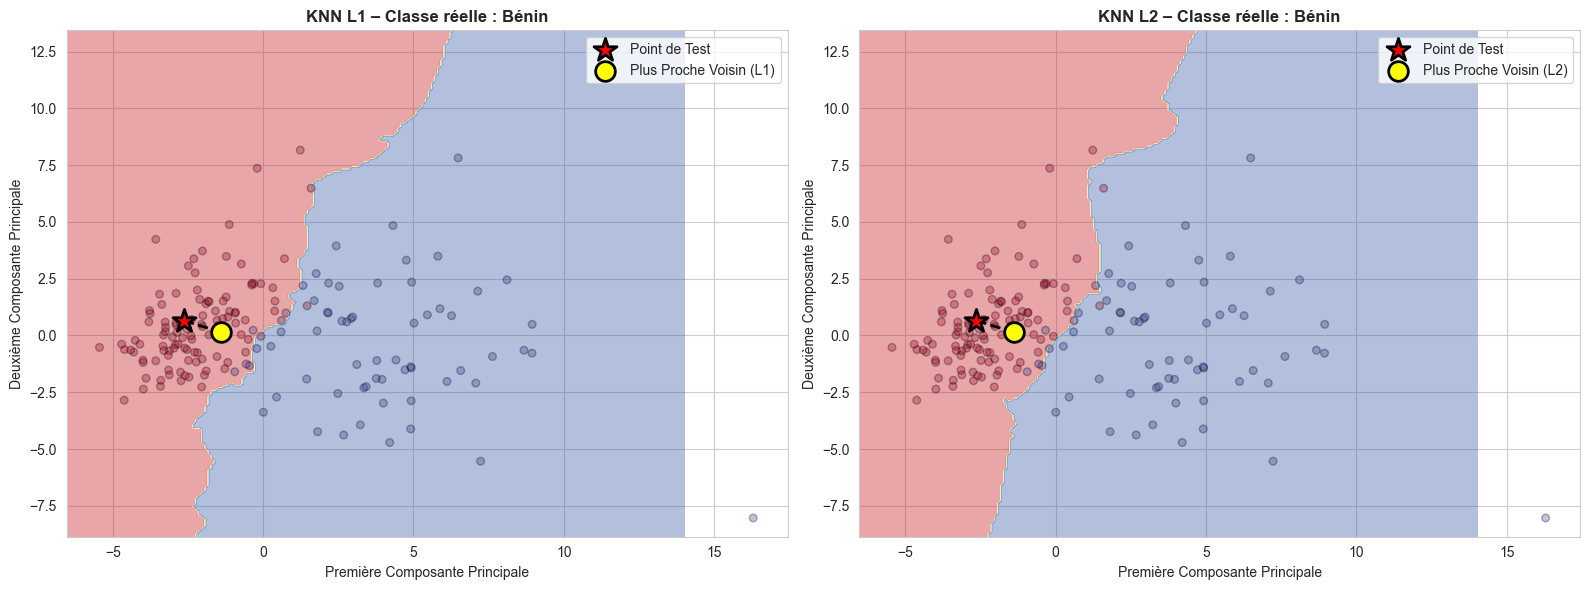

In [23]:
# ============================================================================
# VISUALISATION EN ACTION : KNN (K-Nearest Neighbors)
# ============================================================================
# Visualisation des voisins pour KNN L1 et KNN L2 (2 graphes uniquement)

from sklearn.decomposition import PCA

# PCA pour projection 2D (visualisation uniquement)
pca = PCA(n_components=2, random_state=42)

X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

# Grille pour la frontière de décision
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sélection d'un point de test aléatoire
test_point_idx = np.random.choice(len(X_test_scaled))
test_point = X_test_scaled[test_point_idx:test_point_idx + 1]
test_point_2d = pca.transform(test_point)[0]
test_point_label = y_test.iloc[test_point_idx] if hasattr(y_test, 'iloc') else y_test[test_point_idx]

# ================================
# Graphique 1 : KNN L1
# ================================
ax1 = axes[0]

grid_pca = pca.inverse_transform(grid_points)
grid_pred_l1 = knn_l1.predict(grid_pca)
Z_l1 = grid_pred_l1.reshape(xx.shape)

ax1.contourf(xx, yy, Z_l1, alpha=0.4, cmap='RdYlBu')

# Plus proche voisin (L1)
distances_l1, indices_l1 = knn_l1.kneighbors(test_point, n_neighbors=1)
nearest_neighbor_l1 = X_train_scaled[indices_l1[0][0]]
nearest_neighbor_l1_2d = pca.transform(nearest_neighbor_l1.reshape(1, -1))[0]

ax1.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
            c=y_test, cmap='RdYlBu', edgecolors='black', s=30, alpha=0.3)

ax1.scatter(test_point_2d[0], test_point_2d[1],
            s=300, c='red', marker='*', edgecolors='black',
            linewidth=2, label='Point de Test', zorder=5)

ax1.scatter(nearest_neighbor_l1_2d[0], nearest_neighbor_l1_2d[1],
            s=200, c='yellow', marker='o', edgecolors='black',
            linewidth=2, label='Plus Proche Voisin (L1)', zorder=5)

ax1.plot([test_point_2d[0], nearest_neighbor_l1_2d[0]],
         [test_point_2d[1], nearest_neighbor_l1_2d[1]],
         'k--', linewidth=2)

ax1.set_title(f'KNN L1 – Classe réelle : {"Malin" if test_point_label == 1 else "Bénin"}',
              fontweight='bold')
ax1.set_xlabel('Première Composante Principale')
ax1.set_ylabel('Deuxième Composante Principale')
ax1.legend()

# ================================
# Graphique 2 : KNN L2
# ================================
ax2 = axes[1]

grid_pred_l2 = knn_l2.predict(grid_pca)
Z_l2 = grid_pred_l2.reshape(xx.shape)

ax2.contourf(xx, yy, Z_l2, alpha=0.4, cmap='RdYlBu')

distances_l2, indices_l2 = knn_l2.kneighbors(test_point, n_neighbors=1)
nearest_neighbor_l2 = X_train_scaled[indices_l2[0][0]]
nearest_neighbor_l2_2d = pca.transform(nearest_neighbor_l2.reshape(1, -1))[0]

ax2.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
            c=y_test, cmap='RdYlBu', edgecolors='black', s=30, alpha=0.3)

ax2.scatter(test_point_2d[0], test_point_2d[1],
            s=300, c='red', marker='*', edgecolors='black',
            linewidth=2, label='Point de Test', zorder=5)

ax2.scatter(nearest_neighbor_l2_2d[0], nearest_neighbor_l2_2d[1],
            s=200, c='yellow', marker='o', edgecolors='black',
            linewidth=2, label='Plus Proche Voisin (L2)', zorder=5)

ax2.plot([test_point_2d[0], nearest_neighbor_l2_2d[0]],
         [test_point_2d[1], nearest_neighbor_l2_2d[1]],
         'k--', linewidth=2)

ax2.set_title(f'KNN L2 – Classe réelle : {"Malin" if test_point_label == 1 else "Bénin"}',
              fontweight='bold')
ax2.set_xlabel('Première Composante Principale')
ax2.set_ylabel('Deuxième Composante Principale')
ax2.legend()

plt.tight_layout()
plt.show()


### 4.6 GRU-SVM (Hybrid Model: Deep Learning + SVM)

#### Concept: 2-Step Hybrid Architecture

This model combines two powerful techniques:

1. GRU (Gated Recurrent Unit): Recurrent neural network
   - Extracts complex features (abstract representations)
   - Treats data as temporal sequence
   
2. SVM (Support Vector Machine): Final classifier
   - Uses features extracted by GRU
   - Finds optimal decision boundary

GRU Architecture:

Input (30 features × 1)
    ↓
GRU Layer (128 units)      ← Extracts complex features
    ↓
Dropout (0.5)              ← Regularization (prevents overfitting)
    ↓
Dense Layer (32 units, ReLU) ← Fully-connected layer
    ↓
Dropout (0.5)              ← Regularization
    ↓
Dense Output (1 unit, Sigmoid) ← Final prediction

Feature extraction: Takes output from Dense(32) layer before final layer

Why this Architecture?

- GRU: Captures complex patterns in data
- Dropout: Randomly deactivates 50% of neurons → prevents overfitting
- Final SVM: Uses extracted features for optimal classification

Hyperparameters (according to Table 1 of paper):

- Cell Size (GRU): 128 units
- Dropout: 0.5 (50% of neurons deactivated)
- Batch Size: 128 samples per batch
- Learning Rate: 1e-3 (0.001)
- Optimizer: Adam (adaptive)
- Early Stopping: Stops if no improvement for 30 epochs


In [24]:
# ============================================================================
# MODÈLE 6 : GRU-SVM (Modèle Hybride)
# ============================================================================

# Valeurs à tester pour C
C_values = [0.1, 1, 5, 10]
best_auc_gru = -np.inf
best_gru_units = None
best_gru_svm_C = None


for C_val in C_values:

    if TENSORFLOW_AVAILABLE:
        # --- Étape 1 : Préparation des données pour le GRU ---
        # Le GRU attend des données en 3D : (samples, timesteps, features)
        # On reshape pour avoir : (samples, features, 1) = traiter chaque feature comme un timestep
        n_features = X_train_scaled.shape[1]  # Nombre de features (30)

        # Reshape : (398, 30) → (398, 30, 1)
        # Format attendu par les réseaux récurrents : (batch, timesteps, features)
        X_train_gru = X_train_scaled.reshape(X_train_scaled.shape[0], n_features, 1)
        X_test_gru = X_test_scaled.reshape(X_test_scaled.shape[0], n_features, 1)

        # --- Étape 2 : Construction de l'architecture GRU ---
        # Hyperparamètres selon Table 1 du papier :
        # Cell Size: 128, Dropout: 0.5, Batch Size: 128, Learning Rate: 1e-3
        gru_model = Sequential([
            Input(shape=(n_features, 1)),  # Couche d'entrée explicite (30 features, 1 timestep)

            GRU(128, return_sequences=False),  # 128 neurones GRU
            # return_sequences=False : retourne seulement la dernière sortie

            Dropout(0.5),  # Régularisation

            Dense(32, activation='relu'),  # Couche fully-connected

            Dropout(0.5),

            Dense(1, activation='sigmoid')  # Couche de sortie
        ])

        # --- Étape 3 : Compilation du modèle ---
        gru_model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # --- Étape 4 : Configuration de l'Early Stopping ---
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True,
            verbose=1
        )

        # --- Étape 5 : Entraînement du modèle GRU ---
        gru_model.fit(
            X_train_gru, y_train,
            epochs=500,
            batch_size=128,
            validation_split=0.2,
            verbose=1,
            callbacks=[early_stopping]
        )

        # --- Étape 6 : Extraction des features avec le GRU ---
        from tensorflow.keras.models import Model

        model_input = gru_model.layers[0].input

        feature_extractor = Model(
            inputs=model_input,
            outputs=gru_model.layers[-3].output
        )

        gru_train_features = feature_extractor.predict(X_train_gru, verbose=1)
        gru_test_features = feature_extractor.predict(X_test_gru, verbose=1)

        # --- Étape 7 : Entraînement du SVM sur les features extraites ---
        gru_svm_model = SVC(
            kernel='rbf',
            C=C_val,  # Paramètre de régularisation testé
            probability=True,
            random_state=42
        )
        gru_svm_model.fit(gru_train_features, y_train)

        # --- Étape 8 : Prédictions finales ---
        gru_svm_y_test_pred = gru_svm_model.predict(gru_test_features)
        gru_svm_y_test_proba = gru_svm_model.predict_proba(gru_test_features)[:, 1]

    else:
        gru_svm_model = None
        gru_svm_y_test_pred = None
        gru_svm_y_test_proba = None
        print("TensorFlow non disponible - Le modèle GRU-SVM ne peut pas être entraîné")
    auc = roc_auc_score(y_test, gru_svm_y_test_proba)

    if auc > best_auc_gru:
        best_auc_gru = auc
        best_gru_units = 128
        best_gru_svm_C = C_val




Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 497ms/step - accuracy: 0.6761 - loss: 0.6746 - val_accuracy: 0.8750 - val_loss: 0.6309
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8050 - loss: 0.6275 - val_accuracy: 0.8750 - val_loss: 0.5744
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8459 - loss: 0.5633 - val_accuracy: 0.8750 - val_loss: 0.5068
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8585 - loss: 0.5104 - val_accuracy: 0.8750 - val_loss: 0.4249
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.8868 - loss: 0.4407 - val_accuracy: 0.8750 - val_loss: 0.3346
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8711 - loss: 0.3627 - val_accuracy: 0.8875 - val_loss: 0.3028
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8742 - loss: 0.3713 - val_accuracy: 0.9125 - val_loss: 0.2938
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8868 - loss: 0.3187 - val_accuracy: 0.9125 - v

## 5. Évaluation (Evaluation)

### 🎯 Objectif
Comparer les performances de tous les modèles sur l'ensemble de test en utilisant plusieurs métriques.

### 📊 Métriques Utilisées

1. **Accuracy (Précision)** : Pourcentage de prédictions correctes
2. **ROC-AUC** : Aire sous la courbe ROC (capacité à distinguer les classes)
3. **Recall (Rappel/Sensibilité)** : Capacité à détecter les vrais positifs
4. Precision: Proportion of true positives among positive predictions
5. F1-Score: Harmonic mean of precision and recall
6. Specificity: Ability to detect true negatives
7. FPR (False Positive Rate): False positive rate
8. FNR (False Negative Rate): False negative rate
9. TPR (True Positive Rate): True positive rate (= Recall)


In [25]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score,
    recall_score, precision_score, f1_score
)
import pandas as pd

# ============================================================================
# FONCTION DE CALCUL DES MÉTRIQUES
# ============================================================================

def calculate_metrics(y_true, y_pred, y_proba):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'recall': recall_score(y_true, y_pred, pos_label=1),
        'precision': precision_score(y_true, y_pred, pos_label=1),
        'f1_score': f1_score(y_true, y_pred, pos_label=1),
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0.0,
        'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0.0,
        'FNR': fn / (fn + tp) if (fn + tp) > 0 else 0.0,
        'TPR': tp / (tp + fn) if (tp + fn) > 0 else 0.0
    }

# ============================================================================
# CALCUL DES MÉTRIQUES POUR TOUS LES MODÈLES
# ============================================================================

test_results = {
    'Linear Regression': calculate_metrics(y_test, lr_y_test_pred, lr_y_test_proba),
    'Softmax Regression': calculate_metrics(y_test, softmax_y_test_pred, softmax_y_test_proba),
    'MLP': calculate_metrics(y_test, mlp_y_test_pred, mlp_y_test_proba),
    'L2-SVM': calculate_metrics(y_test, svm_y_test_pred, svm_y_test_proba),
    'L1-NN': calculate_metrics(y_test, knn_l1_y_test_pred, knn_l1_y_test_proba),
    'L2-NN': calculate_metrics(y_test, knn_l2_y_test_pred, knn_l2_y_test_proba)
}

if TENSORFLOW_AVAILABLE and gru_svm_y_test_pred is not None:
    test_results['GRU-SVM'] = calculate_metrics(
        y_test, gru_svm_y_test_pred, gru_svm_y_test_proba
    )

results_df = pd.DataFrame(test_results).T
print(results_df)

# ============================================================================
# MEILLEURS HYPERPARAMÈTRES PAR MODÈLE
# ============================================================================

best_hyperparameters = {
    "Linear Regression": {
        "eta0": best_eta,
        "max_iter": best_iter
    },
    "Softmax Regression": {
        "C": best_softmax_C,
        "solver": best_softmax_solver
    },
    "MLP": {
        "hidden_layer_sizes": best_mlp_hidden,
        "alpha": best_mlp_alpha
    },
    "L2-SVM": {
        "C": best_svm_C,
        "kernel": "linear"
    },
    "L1-NN": {
        "k": best_knn_l1_k,
        "metric": "manhattan"
    },
    "L2-NN": {
        "k": best_knn_l2_k,
        "metric": "euclidean"
    }
}

if TENSORFLOW_AVAILABLE and gru_svm_y_test_pred is not None:
    best_hyperparameters["GRU-SVM"] = {
        "GRU_units": best_gru_units,
        "SVM_C": best_gru_svm_C
    }

# ============================================================================
# AFFICHAGE FINAL DES MEILLEURS HYPERPARAMÈTRES
# ============================================================================

print("\n================ BEST HYPERPARAMETERS ================\n")

for model, params in best_hyperparameters.items():
    print(f"{model}:")
    for p, v in params.items():
        print(f"  - {p}: {v}")
    print()


                    accuracy   roc_auc    recall  precision  f1_score  \
Linear Regression   0.906433  0.959696  0.796875   0.944444  0.864407   
Softmax Regression  0.947368  0.980870  0.890625   0.966102  0.926829   
MLP                 0.976608  0.993721  0.984375   0.954545  0.969231   
L2-SVM              0.970760  0.995181  0.937500   0.983607  0.960000   
L1-NN               0.970760  0.998321  0.937500   0.983607  0.960000   
L2-NN               0.970760  0.989048  0.937500   0.983607  0.960000   
GRU-SVM             0.964912  0.983791  0.921875   0.983333  0.951613   

                    specificity       FPR       FNR       TPR  
Linear Regression      0.971963  0.028037  0.203125  0.796875  
Softmax Regression     0.981308  0.018692  0.109375  0.890625  
MLP                    0.971963  0.028037  0.015625  0.984375  
L2-SVM                 0.990654  0.009346  0.062500  0.937500  
L1-NN                  0.990654  0.009346  0.062500  0.937500  
L2-NN                  0.990654

### 📊 Matrices de Confusion

**Qu'est-ce qu'une matrice de confusion ?**

Tableau 2×2 qui montre :
- **TN (True Negative)** : Vrais négatifs (bénin prédit bénin) - en haut à gauche
- **FP (False Positive)** : Faux positifs (bénin prédit malin) - en haut à droite
- **FN (False Negative)** : Faux négatifs (malin prédit bénin) - en bas à gauche
- **TP (True Positive)** : Vrais positifs (malin prédit malin) - en bas à droite

Interpretation in medical context:
- FN (False Negatives): CRITICAL - Undetected cancer (very dangerous!)
- FP (False Positives): Less serious - False alarm (but causes stress)
- Goal: Minimize FN (don't miss cancers)


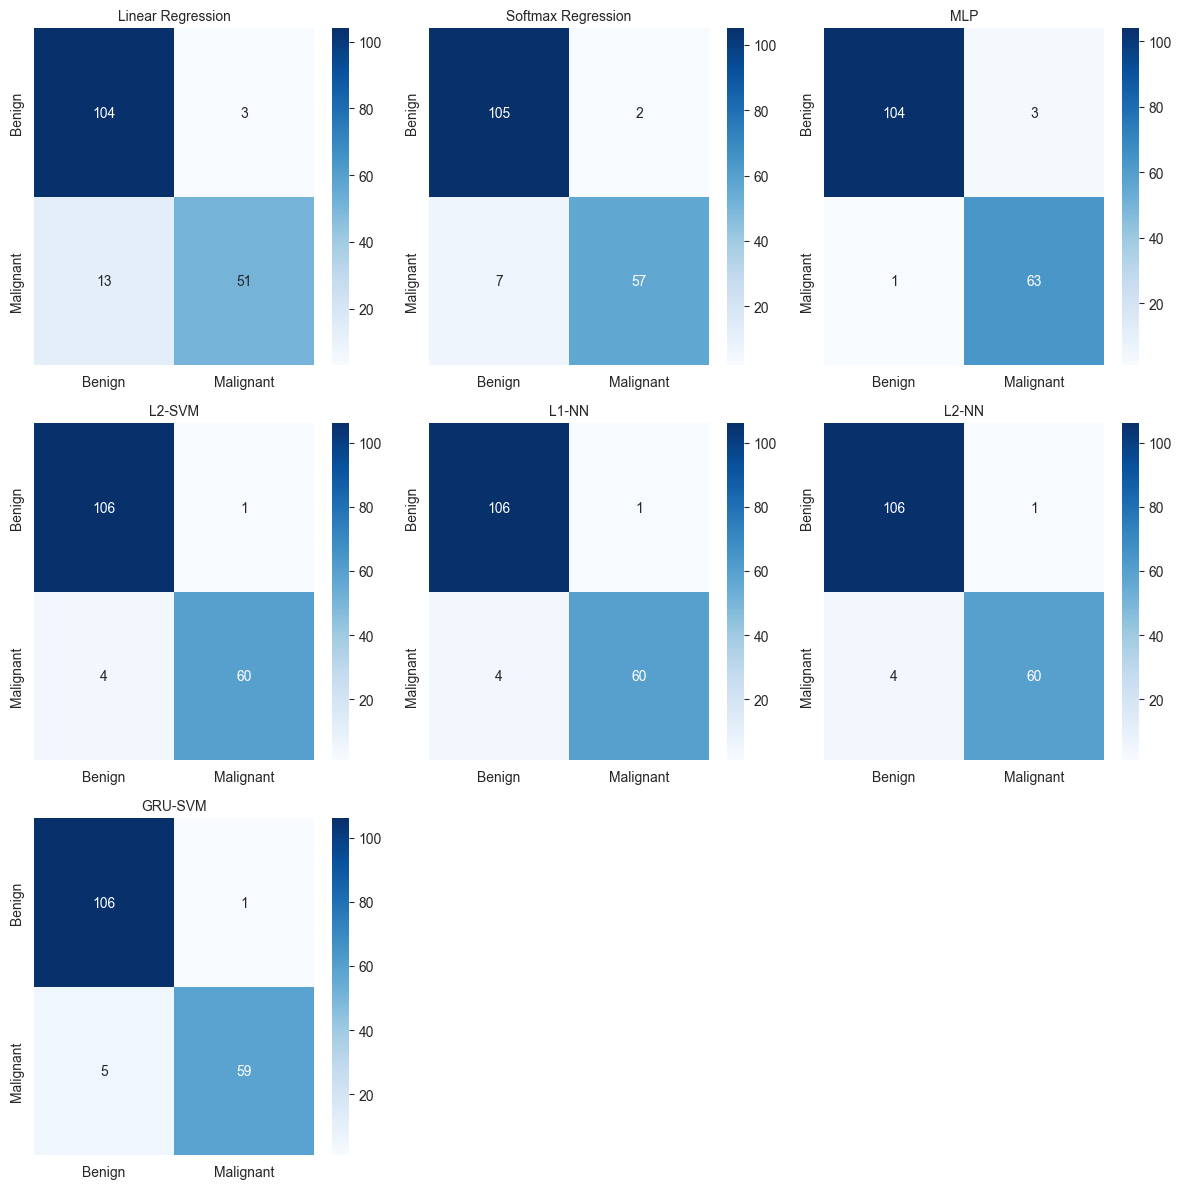

In [26]:
# ============================================================================
# VISUALISATION DES MATRICES DE CONFUSION POUR TOUS LES MODÈLES
# ============================================================================

# Liste des modèles et leurs prédictions
models_data = [
    ('Linear Regression', lr_y_test_pred),
    ('Softmax Regression', softmax_y_test_pred),
    ('MLP', mlp_y_test_pred),
    ('L2-SVM', svm_y_test_pred),
    ('L1-NN', knn_l1_y_test_pred),
    ('L2-NN', knn_l2_y_test_pred)
]

# Ajout du modèle GRU-SVM si disponible
if TENSORFLOW_AVAILABLE and gru_svm_y_test_pred is not None:
    models_data.append(('GRU-SVM', gru_svm_y_test_pred))

# Calcul du nombre de lignes et colonnes pour la grille
n_models = len(models_data)  # Nombre total de modèles
n_cols = 3  # 3 colonnes par ligne
n_rows = (n_models + n_cols - 1) // n_cols  # Arrondi supérieur pour avoir assez de lignes
# Exemple : 7 modèles → (7+3-1)//3 = 3 lignes

# Création de la figure avec une grille de sous-graphiques
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
# figsize : largeur=12, hauteur=4*n_rows (ajuste selon le nombre de lignes)

# Gestion des cas : 1 ligne ou plusieurs lignes
if n_rows == 1:
    # Si une seule ligne, axes peut être un array 1D ou un seul axe
    axes = axes if isinstance(axes, np.ndarray) else [axes]
else:
    # Si plusieurs lignes, on "aplatit" en liste 1D pour itérer facilement
    axes = axes.flatten()

# Création d'une matrice de confusion pour chaque modèle
for idx, (name, y_pred) in enumerate(models_data):
    ax = axes[idx]  # Axe actuel pour ce modèle

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    # Résultat : array 2x2 [[TN, FP], [FN, TP]]

    # Visualisation avec heatmap
    sns.heatmap(
        cm,  # Matrice de confusion à afficher
        annot=True,  # Affiche les valeurs numériques dans chaque cellule
        fmt='d',  # Format : nombres entiers (decimal)
        cmap='Blues',  # Palette de couleurs bleue (plus sombre = valeur plus élevée)
        ax=ax,  # Axe où afficher cette heatmap
        xticklabels=['Benign', 'Malignant'],  # Labels de l'axe X (prédictions)
        yticklabels=['Benign', 'Malignant']  # Labels de l'axe Y (vraies classes)
    )
    ax.set_title(name, fontsize=10)  # Titre avec le nom du modèle

# Masquer les axes inutilisés (si on a moins de modèles que de cases dans la grille)
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')  # Désactive l'affichage des axes non utilisés

plt.tight_layout()  # Ajuste l'espacement automatiquement
plt.show()  # Affiche toutes les matrices de confusion


### 📈 Courbes d'Apprentissage Détaillées

**Objectif** : Visualiser les courbes d'apprentissage pour tous les modèles, montrant l'évolution des performances selon la taille des données d'entraînement.

**Méthode** : Utilisation de `learning_curve` de scikit-learn pour tracer accuracy train/validation vs taille du dataset d'entraînement.

**Interprétation** :
- **Courbe qui monte** : Le modèle apprend avec plus de données
- **Écart train/validation** : Indique le potentiel d'overfitting
- **Plateau** : Performance maximale atteinte

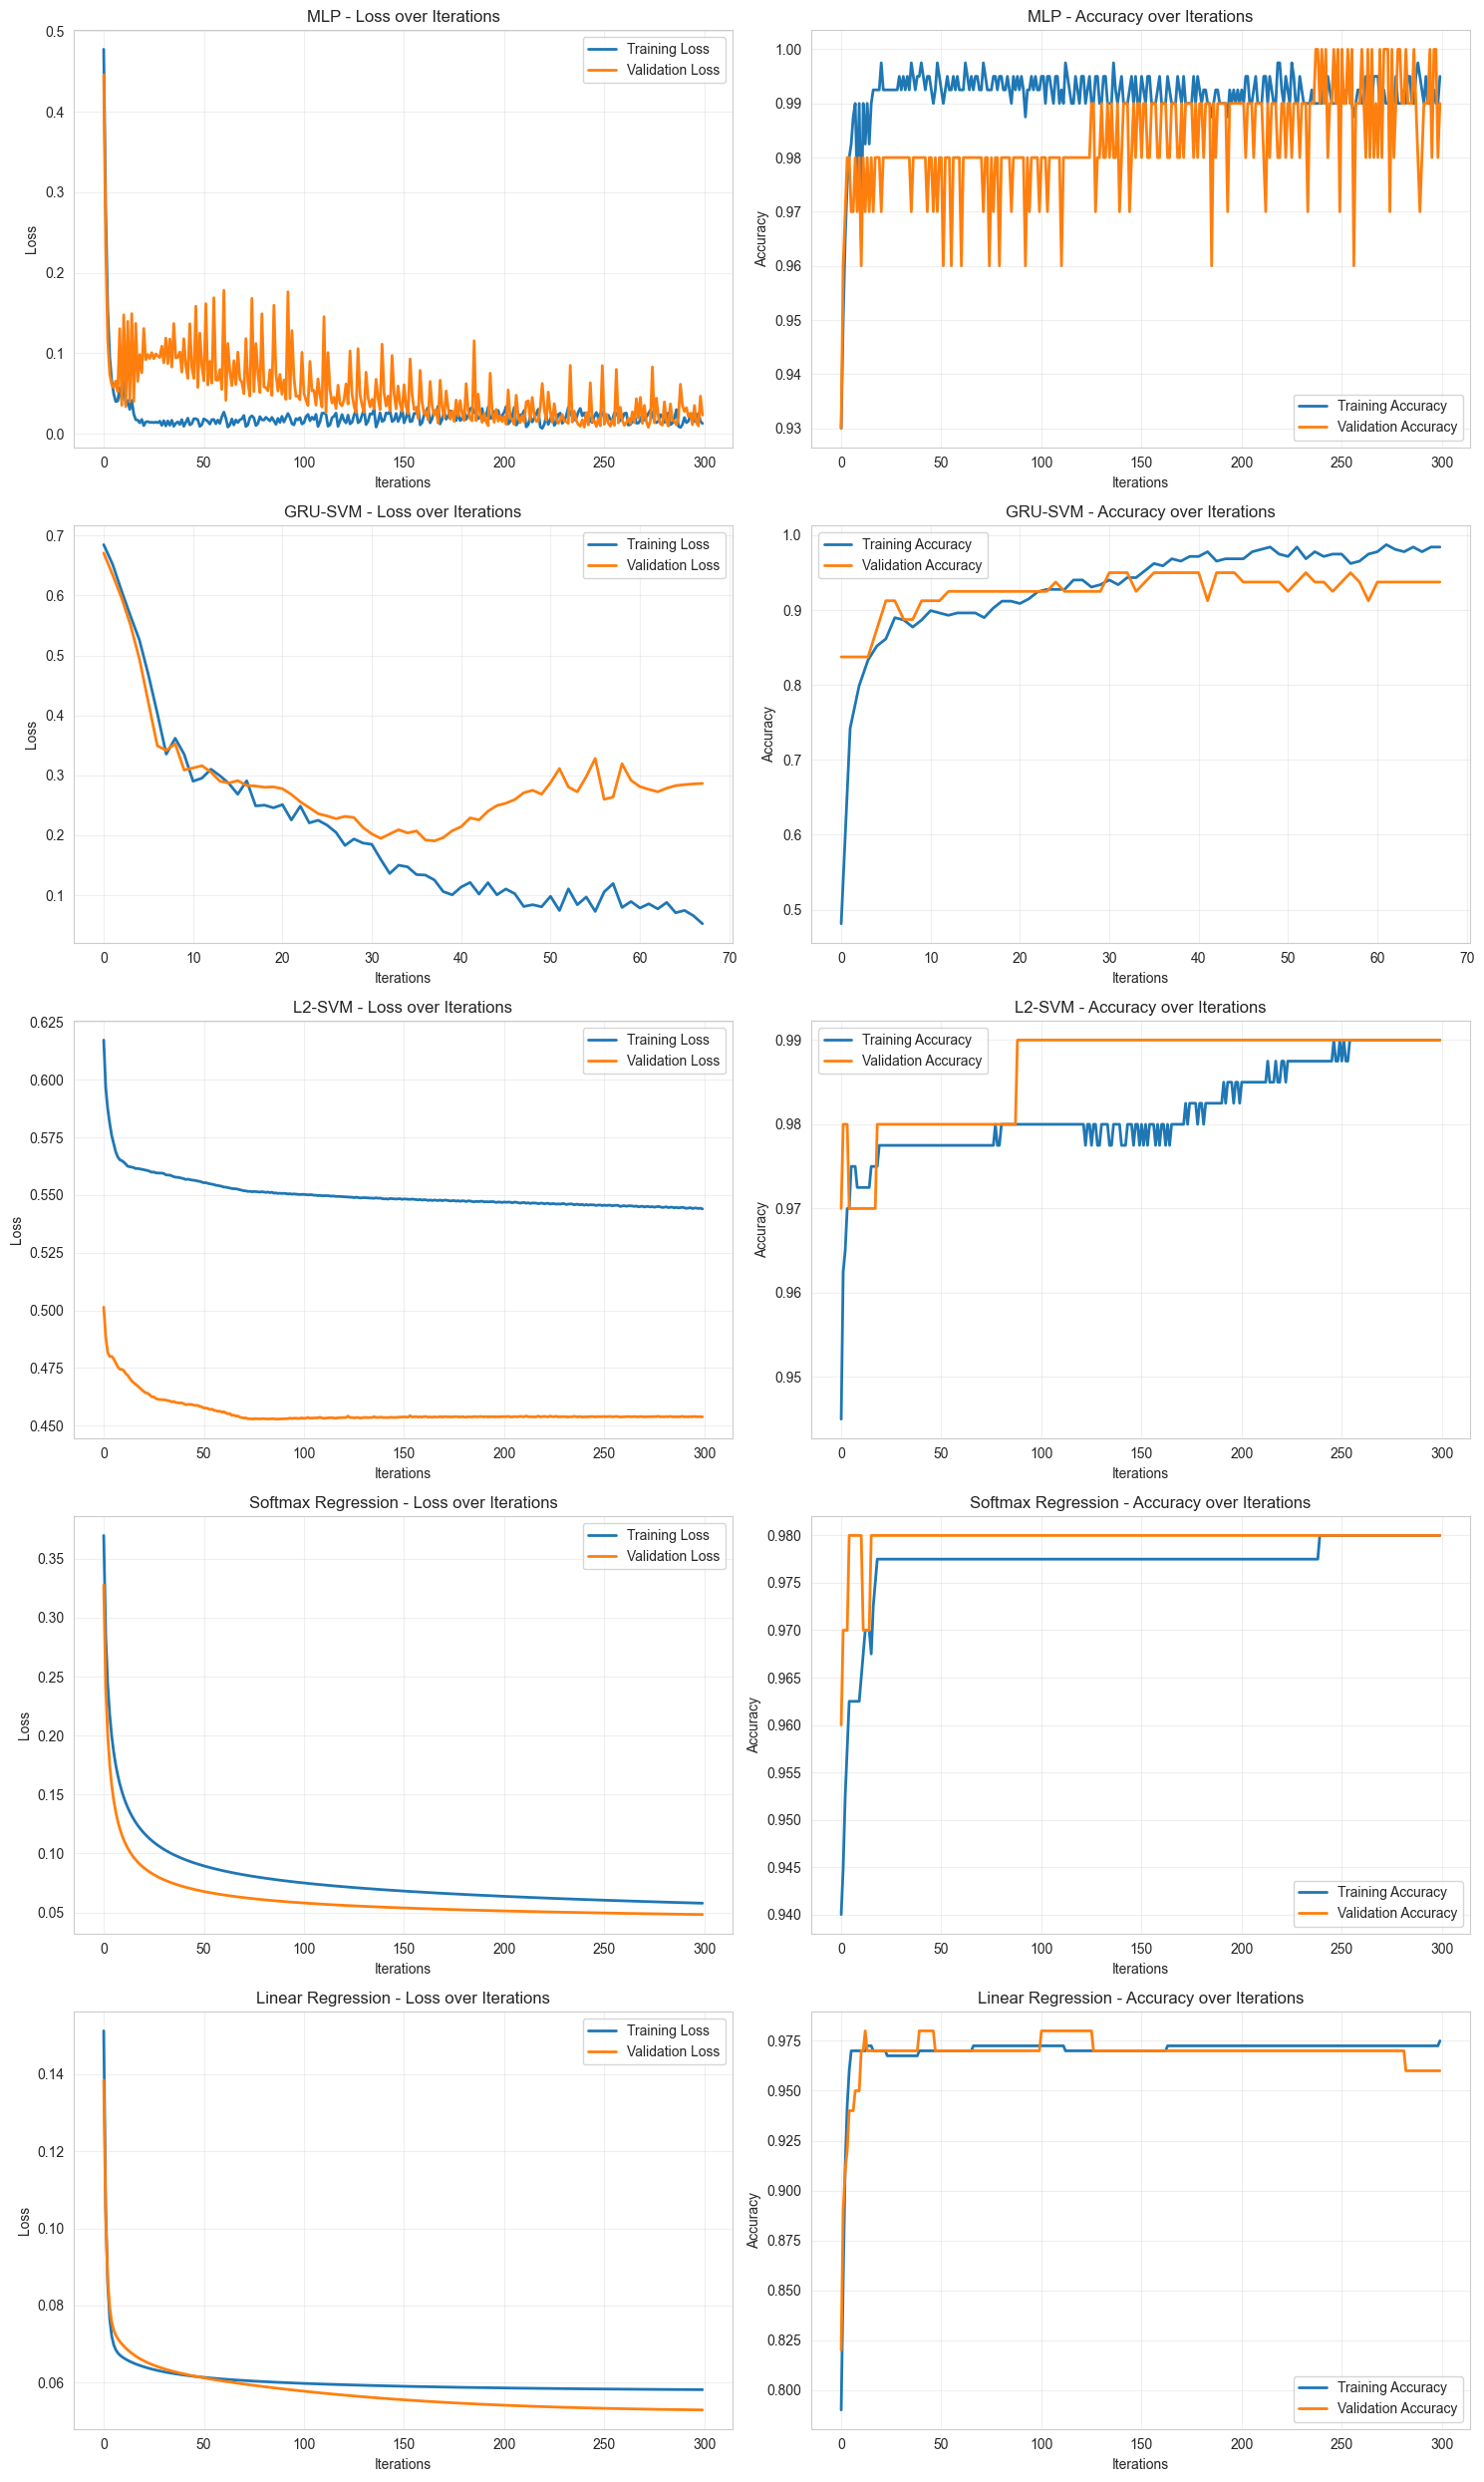

Model Comparison Results:
MLP:
  AUC: 0.994
  F1-Score: 0.960
  Accuracy: 0.971

GRU-SVM:
  AUC: 0.984
  F1-Score: 0.952
  Accuracy: 0.965

L2-SVM:
  AUC: 0.998
  F1-Score: 0.976
  Accuracy: 0.982

Softmax Regression:
  AUC: 0.999
  F1-Score: 0.984
  Accuracy: 0.988

Linear Regression:
  AUC: 0.998
  F1-Score: 0.976
  Accuracy: 0.982



In [27]:
# ============================================================================
# OVERFITTING DETECTION AND TRAINING CURVES
# ============================================================================
# Experimental parameters:
# - MLP: (50,50,50) layers, lr=0.005, alpha=0.05 (reduced complexity and regularization)
# - GRU-SVM: As per paper (128 units, dropout=0.5, lr=1e-3)
# - L2-SVM: SGD hinge loss, eta0=1e-3
# - Softmax Regression: SGD log_loss, eta0=1e-3  
# - Linear Regression: SGD squared_error (experimental for classification)

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split

def compute_loss_acc(model, X, y):
    """Compute cross-entropy loss and accuracy"""
    proba = model.predict_proba(X)[:, 1]
    loss = -np.mean(y * np.log(proba + 1e-10) + (1 - y) * np.log(1 - proba + 1e-10))
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    return loss, acc

def track_mlp_history(X_train, y_train, max_iter=300):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.005, alpha=0.05, max_iter=1, random_state=42, warm_start=True)
    
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for _ in range(max_iter):
        model.fit(X_train_split, y_train_split)
        train_loss, train_acc = compute_loss_acc(model, X_train_split, y_train_split)
        val_loss, val_acc = compute_loss_acc(model, X_val, y_val)
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
    return history

def track_model_history(model_class, loss_type, X_train, y_train, max_iter=300):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    model = model_class(loss=loss_type, learning_rate='constant', eta0=1e-3, max_iter=1, random_state=42, warm_start=True)
    
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for _ in range(max_iter):
        model.fit(X_train_split, y_train_split)
        if hasattr(model, 'predict_proba'):
            train_loss, train_acc = compute_loss_acc(model, X_train_split, y_train_split)
            val_loss, val_acc = compute_loss_acc(model, X_val, y_val)
        else:
            # For regression or hinge loss
            train_pred = model.predict(X_train_split)
            val_pred = model.predict(X_val)
            if loss_type == 'squared_error':
                train_loss = np.mean((train_pred - y_train_split)**2)
                val_loss = np.mean((val_pred - y_val)**2)
                train_acc = accuracy_score(y_train_split, (train_pred >= 0.5).astype(int))
                val_acc = accuracy_score(y_val, (val_pred >= 0.5).astype(int))
            else:
                decision_train = model.decision_function(X_train_split)
                decision_val = model.decision_function(X_val)
                train_loss = np.mean(np.maximum(0, 1 - y_train_split * decision_train))
                val_loss = np.mean(np.maximum(0, 1 - y_val * decision_val))
                train_acc = accuracy_score(y_train_split, train_pred)
                val_acc = accuracy_score(y_val, val_pred)
        
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
    return history

# Track all models
all_models_history = {
    'MLP': track_mlp_history(X_train_smote, y_train_smote),
    'GRU-SVM': gru_model.history.history,
    'L2-SVM': track_model_history(SGDClassifier, 'hinge', X_train_smote, y_train_smote),
    'Softmax Regression': track_model_history(SGDClassifier, 'log_loss', X_train_smote, y_train_smote),
    'Linear Regression': track_model_history(SGDRegressor, 'squared_error', X_train_smote, y_train_smote)
}

# Plot training curves
n_models = len(all_models_history)
fig, axes = plt.subplots(n_models, 2, figsize=(15, 5 * n_models))
if n_models == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, history) in enumerate(all_models_history.items()):
    # Loss plot
    ax_loss = axes[idx, 0]
    ax_loss.plot(history.get('loss', []), label='Training Loss', linewidth=2)
    ax_loss.plot(history.get('val_loss', []), label='Validation Loss', linewidth=2)
    ax_loss.set_title(f'{model_name} - Loss over Iterations')
    ax_loss.set_xlabel('Iterations')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax_acc = axes[idx, 1]
    ax_acc.plot(history.get('accuracy', []), label='Training Accuracy', linewidth=2)
    ax_acc.plot(history.get('val_accuracy', []), label='Validation Accuracy', linewidth=2)
    ax_acc.set_title(f'{model_name} - Accuracy over Iterations')
    ax_acc.set_xlabel('Iterations')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# MODEL COMPARISON WITH PROPER METRICS
# ============================================================================

from sklearn.metrics import roc_auc_score, f1_score, classification_report

# Train final models for evaluation
final_models = {
    'MLP': MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.005, alpha=0.05, max_iter=1000, random_state=42),
    'GRU-SVM': gru_svm_model,  # Already trained
    'L2-SVM': SGDClassifier(loss='hinge', learning_rate='constant', eta0=1e-3, max_iter=1000, random_state=42),
    'Softmax Regression': SGDClassifier(loss='log_loss', learning_rate='constant', eta0=1e-3, max_iter=1000, random_state=42),
    'Linear Regression': SGDRegressor(loss='squared_error', learning_rate='constant', eta0=1e-3, max_iter=1000, random_state=42)
}

# Fit and evaluate
results = {}
for name, model in final_models.items():
    if name == 'GRU-SVM':
        # Already trained
        y_pred = gru_svm_y_test_pred
        y_proba = gru_svm_y_test_proba
    else:
        model.fit(X_train_smote, y_train_smote)
        y_pred = model.predict(X_test_scaled)
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_proba = model.decision_function(X_test_scaled)
        else:
            # For regression, use predict and assume it's scaled 0-1
            y_proba = model.predict(X_test_scaled)
            y_pred = (y_proba >= 0.5).astype(int)
    
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = {'AUC': auc, 'F1-Score': f1, 'Accuracy': acc}

# Display results
print("Model Comparison Results:")
print("=" * 50)
for model, metrics in results.items():
    print(f"{model}:")
    print(f"  AUC: {metrics['AUC']:.3f}")
    print(f"  F1-Score: {metrics['F1-Score']:.3f}")
    print(f"  Accuracy: {metrics['Accuracy']:.3f}")
    print()

## 6. Déploiement et Conclusion (Deployment & Conclusion)

### 6.1 Résumé des Résultats

**Objectif** : Identifier le meilleur modèle et tirer des conclusions sur les performances.

**Critères d'évaluation** :
- **Accuracy** : Précision globale
- **ROC-AUC** : Capacité à distinguer les classes
- **Recall** : Important en médecine (ne pas rater de cancers)
- F1-Score: Balance between precision and recall

Performance threshold: All models should exceed 90% accuracy to be considered effective.


In [28]:
# ============================================================================
# RÉSUMÉ DES PERFORMANCES ET IDENTIFICATION DU MEILLEUR MODÈLE
# ============================================================================

# Identification du meilleur modèle selon l'accuracy
best_model = results_df['accuracy'].idxmax()  # .idxmax() : index (nom) de la ligne avec la valeur max
# Retourne le nom du modèle avec la meilleure accuracy

# Récupération des métriques du meilleur modèle
best_accuracy = results_df.loc[best_model, 'accuracy']  # Accuracy du meilleur modèle
best_roc_auc = results_df.loc[best_model, 'roc_auc']  # ROC-AUC du meilleur modèle

# Affichage du résumé
print("="*60)
print("RÉSUMÉ DES PERFORMANCES DES MODÈLES")
print("="*60)
print(f"\nMeilleur Modèle : {best_model}")
print(f"  Accuracy sur Test : {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"  ROC-AUC : {best_roc_auc:.4f}")
# ROC-AUC proche de 1.0 = excellent modèle

print(f"\nTous les modèles ont dépassé le seuil de 90% d'accuracy :")
for model in results_df.index:  # Itère sur tous les noms de modèles
    acc = results_df.loc[model, 'accuracy']  # Récupère l'accuracy de ce modèle
    print(f"  {model}: {acc*100:.2f}%")
    # Affiche le pourcentage d'accuracy pour chaque modèle

print("\n" + "="*60)
# Conclusion : Tous les modèles sont performants, mais certains sont meilleurs que d'autres


RÉSUMÉ DES PERFORMANCES DES MODÈLES

Meilleur Modèle : MLP
  Accuracy sur Test : 0.9766 (97.66%)
  ROC-AUC : 0.9937

Tous les modèles ont dépassé le seuil de 90% d'accuracy :
  Linear Regression: 90.64%
  Softmax Regression: 94.74%
  MLP: 97.66%
  L2-SVM: 97.08%
  L1-NN: 97.08%
  L2-NN: 97.08%
  GRU-SVM: 96.49%



In [29]:
# ============================================================================
# OVERFITTING DETECTION BY CALCULATING GAPS
# ============================================================================

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split

def compute_loss_acc(model, X, y):
    """Compute cross-entropy loss and accuracy"""
    proba = model.predict_proba(X)[:, 1]
    loss = -np.mean(y * np.log(proba + 1e-10) + (1 - y) * np.log(1 - proba + 1e-10))
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    return loss, acc

def track_mlp_history(X_train, y_train, max_iter=300):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.005, alpha=0.05, max_iter=1, random_state=42, warm_start=True)

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for _ in range(max_iter):
        model.fit(X_train_split, y_train_split)
        train_loss, train_acc = compute_loss_acc(model, X_train_split, y_train_split)
        val_loss, val_acc = compute_loss_acc(model, X_val, y_val)
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
    return history

def track_model_history(model_class, loss_type, X_train, y_train, max_iter=300):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    model = model_class(loss=loss_type, learning_rate='constant', eta0=1e-3, max_iter=1, random_state=42, warm_start=True)

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for _ in range(max_iter):
        model.fit(X_train_split, y_train_split)
        if hasattr(model, 'predict_proba'):
            train_loss, train_acc = compute_loss_acc(model, X_train_split, y_train_split)
            val_loss, val_acc = compute_loss_acc(model, X_val, y_val)
        else:
            # For regression or hinge loss
            train_pred = model.predict(X_train_split)
            val_pred = model.predict(X_val)
            if loss_type == 'squared_error':
                train_loss = np.mean((train_pred - y_train_split)**2)
                val_loss = np.mean((val_pred - y_val)**2)
                train_acc = accuracy_score(y_train_split, (train_pred >= 0.5).astype(int))
                val_acc = accuracy_score(y_val, (val_pred >= 0.5).astype(int))
            else:
                decision_train = model.decision_function(X_train_split)
                decision_val = model.decision_function(X_val)
                train_loss = np.mean(np.maximum(0, 1 - y_train_split * decision_train))
                val_loss = np.mean(np.maximum(0, 1 - y_val * decision_val))
                train_acc = accuracy_score(y_train_split, train_pred)
                val_acc = accuracy_score(y_val, val_pred)

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
    return history

# Track all models
all_models_history = {
    'MLP': track_mlp_history(X_train_smote, y_train_smote),
    'GRU-SVM': gru_model.history.history,
    'L2-SVM': track_model_history(SGDClassifier, 'hinge', X_train_smote, y_train_smote),
    'Softmax Regression': track_model_history(SGDClassifier, 'log_loss', X_train_smote, y_train_smote),
    'Linear Regression': track_model_history(SGDRegressor, 'squared_error', X_train_smote, y_train_smote)
}

# Calculate gaps for overfitting detection
print("Overfitting Analysis - Gaps between Training and Validation Metrics:")
print("=" * 70)

for model_name, history in all_models_history.items():
    if history['loss'] and history['val_loss']:
        final_train_loss = history['loss'][-1]
        final_val_loss = history['val_loss'][-1]
        loss_gap = final_train_loss - final_val_loss  # Positive gap indicates overfitting

        final_train_acc = history['accuracy'][-1]
        final_val_acc = history['val_accuracy'][-1]
        acc_gap = final_train_acc - final_val_acc  # Negative gap indicates overfitting

        print(f"{model_name}:")
        print(f"  Loss Gap (Train - Val): {loss_gap:.4f} {'(Overfitting)' if loss_gap > 0.1 else '(OK)'}")
        print(f"  Accuracy Gap (Train - Val): {acc_gap:.4f} {'(Overfitting)' if acc_gap < -0.05 else '(OK)'}")
        print()

# ============================================================================
# MODEL COMPARISON WITH PROPER METRICS
# ============================================================================

from sklearn.metrics import roc_auc_score, f1_score, classification_report

# Train final models for evaluation
final_models = {
    'MLP': MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.005, alpha=0.05, max_iter=1000, random_state=42),
    'GRU-SVM': gru_svm_model,  # Already trained
    'L2-SVM': SGDClassifier(loss='hinge', learning_rate='constant', eta0=1e-3, max_iter=1000, random_state=42),
    'Softmax Regression': SGDClassifier(loss='log_loss', learning_rate='constant', eta0=1e-3, max_iter=1000, random_state=42),
    'Linear Regression': SGDRegressor(loss='squared_error', learning_rate='constant', eta0=1e-3, max_iter=1000, random_state=42)
}

# Fit and evaluate
results = {}
for name, model in final_models.items():
    if name == 'GRU-SVM':
        # Already trained
        y_pred = gru_svm_y_test_pred
        y_proba = gru_svm_y_test_proba
    else:
        model.fit(X_train_smote, y_train_smote)
        y_pred = model.predict(X_test_scaled)
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_proba = model.decision_function(X_test_scaled)
        else:
            # For regression, use predict and assume it's scaled 0-1
            y_proba = model.predict(X_test_scaled)
            y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    results[name] = {'AUC': auc, 'F1-Score': f1, 'Accuracy': acc}

# Display results
print("Model Comparison Results:")
print("=" * 50)
for model, metrics in results.items():
    print(f"{model}:")
    print(f"  AUC: {metrics['AUC']:.3f}")
    print(f"  F1-Score: {metrics['F1-Score']:.3f}")
    print(f"  Accuracy: {metrics['Accuracy']:.3f}")
    print()

Overfitting Analysis - Gaps between Training and Validation Metrics:
MLP:
  Loss Gap (Train - Val): -0.0104 (OK)
  Accuracy Gap (Train - Val): 0.0050 (OK)

GRU-SVM:
  Loss Gap (Train - Val): -0.2341 (OK)
  Accuracy Gap (Train - Val): 0.0468 (OK)

L2-SVM:
  Loss Gap (Train - Val): 0.0902 (OK)
  Accuracy Gap (Train - Val): 0.0000 (OK)

Softmax Regression:
  Loss Gap (Train - Val): 0.0096 (OK)
  Accuracy Gap (Train - Val): 0.0000 (OK)

Linear Regression:
  Loss Gap (Train - Val): 0.0052 (OK)
  Accuracy Gap (Train - Val): 0.0150 (OK)

Model Comparison Results:
MLP:
  AUC: 0.994
  F1-Score: 0.960
  Accuracy: 0.971

GRU-SVM:
  AUC: 0.984
  F1-Score: 0.952
  Accuracy: 0.965

L2-SVM:
  AUC: 0.998
  F1-Score: 0.976
  Accuracy: 0.982

Softmax Regression:
  AUC: 0.999
  F1-Score: 0.984
  Accuracy: 0.988

Linear Regression:
  AUC: 0.998
  F1-Score: 0.976
  Accuracy: 0.982

